In [40]:
import dask.dataframe as dd
import dask_geopandas as dg
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely.wkt
import utilities
from calitp import *
from shared_utils import geography_utils, utils

### Load in Provider Maps
* These maps contain areas that *do not* have data coverage by providers. 

In [41]:
verizon = gpd.read_parquet(
"gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_all_counties.parquet")

In [42]:
verizon.geometry.is_valid.all()

True

In [43]:
att = gpd.read_parquet(
"gs://calitp-analytics-data/data-analyses/cellular_coverage/att_all_counties.parquet")

In [44]:
# Make a copy of ATT for testing
att2 = att.copy()

In [45]:
# simplify the geometry
att2["geometry"] = att2.geometry.simplify(tolerance=25)

In [46]:
att2.shape

(3, 1)

<AxesSubplot:>

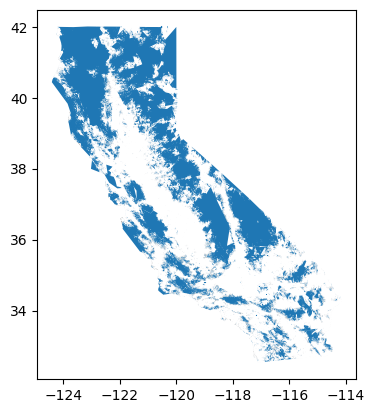

In [47]:
att2.plot()

### Load in Routes 

In [48]:
unique_routes = utilities.load_unique_routes_df()

In [49]:
unique_routes.geometry.is_valid.all()

True

In [50]:
# Ensure CRS are the same
unique_routes = unique_routes.to_crs(att2.crs)

In [51]:
unique_routes.crs == att2.crs 

True

In [52]:
# B/c route names and route ids can be the same across different agencies,
# Add these 3 different columns so the route will have a unique identifier.
# Just in case I want to loop through everything
unique_routes['long_route_name'] = unique_routes['route_name'] + unique_routes['route_id'] + ' '  + ' ' + unique_routes['agency']

In [53]:
unique_routes.long_route_name.nunique() == len(unique_routes) 

True

#### Splitting the df 

In [54]:
# Split this large dataframe into 5
# https://stackoverflow.com/questions/17315737/split-a-large-pandas-dataframe
df_split = np.array_split(unique_routes, 5)

In [63]:
# Grab split out df for testing 
unique_routes1 = df_split[0]
unique_routes2 = df_split[1]
unique_routes3 = df_split[2]
unique_routes4 = df_split[3]
unique_routes5 = df_split[4]

In [56]:
# Checks
unique_routes1.crs == att2.crs, len(unique_routes1), type(unique_routes1)

(True, 566, geopandas.geodataframe.GeoDataFrame)

#### Testing with certain routes - Help
* Routes that gave me issues the first time around
* Getting an error? `TopologyException: Input geom 1 is invalid: Hole lies outside shell at -124.1036 40.437482000000003`

In [71]:
# Routes from analysis v1 that didn't make sense
routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Long Beach/San Pedro"
]

In [72]:
unique_routes_subset = unique_routes[unique_routes["route_name"].isin(routes_wanted)]

In [75]:
len(unique_routes_subset)

22

In [77]:
unique_routes_subset.geometry.is_valid.all()

True

In [79]:
unique_routes_subset.crs == att2.crs

True

In [76]:
intersect_subset = gpd.overlay(unique_routes_subset, att2, how="intersection")

GEOSException: TopologyException: Input geom 1 is invalid: Hole lies outside shell at -124.1036 40.437482000000003

#### Test in a loop

In [65]:
# Grab unique long route names into a list from subsetted df 
unique_routes_subset_names_list = unique_routes5.long_route_name.unique().tolist()

In [58]:
# Empty dataframe to hold each district after clipping
intersected_routes = pd.DataFrame()

In [66]:
# Test with subsetted unique routes
for i in unique_routes_subset_names_list:
    unique_routes5  = unique_routes5[unique_routes5.long_route_name == i].reset_index(
            drop=True
    )

    # https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
    intersect = gpd.overlay(unique_routes5, att2, how="intersection")
    intersected_routes = pd.concat([intersected_routes, intersect], axis=0)
    print(f"Done intersecting & concatting for {i}")

Done intersecting & concatting for Placerita/Hart641  Santa Clarita Transit
Done intersecting & concatting for La Mesa Jr High642  Santa Clarita Transit
Done intersecting & concatting for Arroyo Seco Jr High643  Santa Clarita Transit
Done intersecting & concatting for La Mesa Jr High644  Santa Clarita Transit
Done intersecting & concatting for Magic Mountain/Seco Canyon7  Santa Clarita Transit
Done intersecting & concatting for North Hollywood757  Santa Clarita Transit
Done intersecting & concatting for Warner Center791  Santa Clarita Transit
Done intersecting & concatting for Century City792  Santa Clarita Transit
Done intersecting & concatting for Union Station794  Santa Clarita Transit
Done intersecting & concatting for Warner Center796  Santa Clarita Transit
Done intersecting & concatting for Century City797  Santa Clarita Transit
Done intersecting & concatting for Los Angeles799  Santa Clarita Transit
Done intersecting & concatting for Harvey West/Emeline04  Santa Cruz Metropolita

In [67]:
intersected_routes.shape

(0, 7)

In [61]:
# Grab unique long route names for entire routes_df into a list
unique_routes_names_list = unique_routes.long_route_name.unique().tolist()

In [62]:
# Test with complete unique routes gdf
"""
for i in unique_routes_names_list:
    unique_routes  = unique_routes[unique_routes.long_route_name == i].reset_index(
            drop=True
    )

    # https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
    intersect = gpd.overlay(unique_routes, att2, how="intersection")
    intersected_routes = pd.concat([intersected_routes, intersect], axis=0)
    print(f"Done intersecting & concatting for {i}") """

'\nfor i in unique_routes_names_list:\n    unique_routes  = unique_routes[unique_routes.long_route_name == i].reset_index(\n            drop=True\n    )\n\n    # https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html\n    intersect = gpd.overlay(unique_routes, att2, how="intersection")\n    intersected_routes = pd.concat([intersected_routes, intersect], axis=0)\n    print(f"Done intersecting & concatting for {i}") '